# Preventing Customer Churn Using Machine Learning

## Introduction

### Project Description  
RossTeleKom aims to improve customer retention and reduce churn. To achieve this, a machine learning model will be developed to predict, in advance, the likelihood of a customer terminating their contract. At-risk customers will be offered special incentives and promo codes.

The goal of this project is to create an effective churn prediction model based on analysis of customer personal data, subscription details, connected services, and contract history.

### Data Description  
The project data consists of four tables:

- **`contract_new.csv`** – Contract information:  
  - `customerID` – Unique customer identifier  
  - `BeginDate` – Contract start date  
  - `EndDate` – Contract end date (if filled, the customer has churned)  
  - `Type` – Payment type (Monthly or Long-term)  
  - `PaperlessBilling` – Billing method (Electronic or Paper)  
  - `PaymentMethod` – Payment method  
  - `MonthlyCharges` – Customer’s monthly charges  
  - `TotalCharges` – Total charges accumulated

- **`personal_new.csv`** – Personal customer information:  
  - `customerID` – Unique customer identifier  
  - `gender` – Customer gender  
  - `SeniorCitizen` – Indicates if the customer is a senior citizen (1 = yes, 0 = no)  
  - `Partner` – Indicates if the customer has a spouse/partner  
  - `Dependents` – Indicates if the customer has dependents

- **`internet_new.csv`** – Internet service details:  
  - `customerID` – Unique customer identifier  
  - `InternetService` – Type of internet connection (DSL, Fiber optic, None)  
  - `OnlineSecurity` – Online security service subscription  
  - `OnlineBackup` – Cloud backup service presence  
  - `DeviceProtection` – Device protection service presence  
  - `TechSupport` – Tech support availability  
  - `StreamingTV` – Streaming TV subscription  
  - `StreamingMovies` – Streaming movie service subscription

- **`phone_new.csv`** – Landline phone service details:  
  - `customerID` – Unique customer identifier  
  - `MultipleLines` – Indicates if the customer has multiple phone lines

The key identifier across all tables is `customerID`. The data is current as of February 1, 2020.

### Project Objectives  
- Build models to predict the probability of customer churn.  
- Analyze which features have the strongest impact on churn probability.  
- Select and train the optimal machine learning model.  
- Develop business recommendations to reduce customer churn.

### Problem Conditions  
- Target variable: whether a customer churned (`EndDate` filled = churned, empty = retained).  
- Use data from all four tables, merging them by `customerID`.  
- Train at least two different machine learning models.  
- Perform hyperparameter tuning for at least one model.  
- Compare models by evaluation metrics and choose the best solution.  
- Evaluate model performance on a separate test set.

### Workflow Stages  
**Stage 1: Data Loading and Initial Analysis**  
- Load all source tables.  
- Check for missing values, duplicates, and data errors.

**Stage 2: Exploratory Analysis and Feature Engineering**  
- Explore feature distributions.  
- Verify and correct data types.  
- Identify important features and potentially create new features.

**Stage 3: Data Merging**  
- Merge tables into a single dataset using `customerID`.

**Stage 4: Data Preparation**  
- Scale numerical features.  
- Encode categorical features.  
- Split data into training and test sets.

**Stage 5: Model Training**  
- Build multiple machine learning models (e.g., logistic regression, random forest, gradient boosting).  
- Perform hyperparameter tuning for at least one model.

**Stage 6: Model Evaluation**  
- Compare models using metrics (e.g., Accuracy, Precision, Recall, F1-score, ROC-AUC).  
- Select the best model based on test results.

**Stage 7: Conclusions and Business Recommendations**  
- Interpret the results.  
- Provide recommendations for using the model to predict customer churn in a real business environment.

### Expected Outcomes  
- A reliable model for predicting customer churn.  
- Identification of key features influencing churn probability.  
- Actionable recommendations for TeleDom to retain customers based on data analysis.

This project will help the company not only reduce churn but also increase customer loyalty by proactively addressing churn risk.  

# Data Preprocessing 
**Loading Required Libraries**

In [32]:
# 📚 Стандартные библиотеки
import os
import random
import datetime
from functools import reduce
import time
from time import time as now
import warnings
warnings.filterwarnings("ignore")

# 📊 Работа с данными
import numpy as np
import pandas as pd

# 📈 Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 📦 Модели и пайплайны
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# 🧹 Предобработка
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# 🧮 Алгоритмы
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# 📏 Гиперпараметрические распределения
from scipy.stats import uniform, randint

# 🔍 Валидация и метрики
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, PrecisionRecallDisplay,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# 🔧 Утилиты
from sklearn.utils import shuffle
from sklearn.inspection import permutation_importance

# 📏 Корреляционный анализ
import phik
from phik.report import plot_correlation_matrix

# 🔍 Интерпретируемость
import shap

# 📋 Автоматический EDA
from ydata_profiling import ProfileReport

**Loading raw datasets**

In [5]:
# Paths to files
local_paths = {
    "contract": "contract_new.csv",
    "personal": "personal_new.csv",
    "internet": "internet_new.csv",
    "phone": "phone_new.csv",
}

server_paths = {
    "contract": "https://code.s3.yandex.net/datasets/contract_new.csv",
    "personal": "https://code.s3.yandex.net/datasets/personal_new.csv",
    "internet": "https://code.s3.yandex.net/datasets/internet_new.csv",
    "phone": "https://code.s3.yandex.net/datasets/phone_new.csv",
}

# Function for safe data loading
def load_data_safely(name, local_path, server_path, sep=",", decimal=".", encoding="utf-8"):
    """
    Loads data, first checking for a local file, then a server URL.

    Parameters:
        name (str): Name of the dataset
        local_path (str): Local file path
        server_path (str): Server file URL
        sep (str): Column separator (default ',')
        decimal (str): Decimal separator (default '.')
        encoding (str): File encoding (default 'utf-8')

    Returns:
        pd.DataFrame: Loaded DataFrame or None if an error occurred
    """
    try:
        if os.path.exists(local_path):
            data = pd.read_csv(local_path, sep=sep, decimal=decimal, encoding=encoding)
            print(f"✅ Successfully loaded file {name} from local path: {local_path}")
        else:
            data = pd.read_csv(server_path, sep=sep, decimal=decimal, encoding=encoding)
            print(f"✅ Successfully loaded file {name} from server: {server_path}")
        return data
    except FileNotFoundError:
        print(f"❌ Error: File {name} not found — {local_path} or {server_path}")
    except pd.errors.ParserError:
        print(f"❌ Error: Invalid data format — {local_path} or {server_path}")
    except Exception as e:
        print(f"❌ Unknown error while loading {name}: {e}")

# Loading all datasets
datasets = {
    name: load_data_safely(name, local_paths[name], server_paths[name])
    for name in local_paths
}

# Function for reviewing data
def overview_data(data, name):
    """
    Displays basic information about the DataFrame: first rows, shape, dtypes, missing values, duplicates.

    Parameters:
        data (pd.DataFrame): DataFrame to review
        name (str): Name of the dataset
    """
    if data is not None:
        print(f"\n📄 Dataset information: {name}")
        print('-' * 40)
        print(f"Table size: {data.shape}")
        print("\nFirst 5 rows:")
        display(data.head())
        print("\nData types:")
        print(data.dtypes)
        print("\nMissing values per column:")
        print(data.isnull().sum())
        print("\nNumber of duplicate rows:")
        print(data.duplicated().sum())
        print('-' * 40)
        data.info()
    else:
        print(f"❗ Data for {name} was not loaded.")

# Display information for each loaded dataset
for name, data in datasets.items():
    overview_data(data, name)

# Assign DataFrames to separate variables for convenience
contract = datasets["contract"]
personal = datasets["personal"]
internet = datasets["internet"]
phone = datasets["phone"]

✅ Successfully loaded file contract from server: https://code.s3.yandex.net/datasets/contract_new.csv
✅ Successfully loaded file personal from server: https://code.s3.yandex.net/datasets/personal_new.csv
✅ Successfully loaded file internet from server: https://code.s3.yandex.net/datasets/internet_new.csv
✅ Successfully loaded file phone from server: https://code.s3.yandex.net/datasets/phone_new.csv

📄 Dataset information: contract
----------------------------------------
Table size: (7043, 8)

First 5 rows:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



Data types:
customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

Missing values per column:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Number of duplicate rows:
0
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Data types:
customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object

Missing values per column:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Number of duplicate rows:
0
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

📄 Dataset information: internet
----------------------------------------
Table size: (5517, 8)

First 5 rows:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Data types:
customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object

Missing values per column:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Number of duplicate rows:
0
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   obj

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Data types:
customerID       object
MultipleLines    object
dtype: object

Missing values per column:
customerID       0
MultipleLines    0
dtype: int64

Number of duplicate rows:
0
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


## Conclusion:

- All four datasets were successfully loaded without missing values or duplicates.  
- Each table uses `customerID` as a common identifier, enabling merging into a single dataset.  
- In the `contract` dataset, the following issues were identified:  
  - Columns `BeginDate` and `EndDate` are of type `object` (string) and need to be converted to `datetime`.  
  - Column `TotalCharges` is of type `object` but should be numeric (`float`); it requires conversion with error handling.  
- In the `personal`, `internet`, and `phone` tables, data types are correct for initial analysis, but categorical features must be encoded before modeling.  
- The datasets have different row counts:  
  - `contract` and `personal` each contain 7,043 records;  
  - `internet` contains 5,517 records;  
  - `phone` contains 6,361 records.  
- This implies that when merging, missing values must be handled carefully, as not all customers subscribed to internet or landline services.

---

### Next Steps:

- **Convert data to appropriate types:**  
  - Transform `BeginDate` and `EndDate` into `datetime`.  
  - Convert `TotalCharges` to `float`.  
- **Check for anomalies and data errors.**  
- **Merge all tables on `customerID` to form a single DataFrame.**  
- **Define the target variable (`churn`):**  
  - A customer is considered churned (`churn = 1`) if `EndDate` has a termination date.  
  - If `EndDate` is `"No"` or missing, the customer is retained (`churn = 0`).  

# EDA

## Merging Tables
Merge all tables for further analysis

In [9]:
data_frames = [contract, internet, personal, phone]
data = reduce(lambda  left,right: pd.merge(left ,right, on=['customerID'],
                                            how='outer'), data_frames)
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,631.73,DSL,No,Yes,No,Yes,Yes,No,Female,0,Yes,Yes,No
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,539.1,DSL,No,No,No,No,No,Yes,Male,0,No,No,Yes
2,0004-TLHLJ,2019-09-01,No,Month-to-month,Yes,Electronic check,73.9,406.45,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No,No
3,0011-IGKFF,2018-12-01,No,Month-to-month,Yes,Electronic check,98.0,1372.0,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,1,Yes,No,No
4,0013-EXCHZ,2019-09-01,No,Month-to-month,Yes,Mailed check,83.9,444.67,Fiber optic,No,No,No,Yes,Yes,No,Female,1,Yes,No,No


In [10]:
# Оставляем только числовые и булевы признаки (без текстов)
data_for_profile = data.select_dtypes(include=["number", "bool"])

# Строим профиль
profile = ProfileReport(
    data_for_profile,
    minimal=True, 
    explorative=True
)

# Показываем в ноутбуке
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 442.90it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 📋 Interim Conclusions After Initial Data Processing

- After merging all tables, a single DataFrame was obtained:
  - **Number of rows**: 7,043
  - **Number of columns**: 20
  - **Data types**:
    - **10 categorical features** (`object`)
    - **9 boolean features** (`bool`)
    - **1 numeric feature** (`numeric`)
- **Duplicates**: none found.
- **Missing values**:
  - A total of **11,364** missing entries were detected.
  - Most missing values are related to internet and phone services—some customers did not subscribe to these services.
- **`EndDate` column**:
  - The value `'No'` appears **5,174 times**, indicating that roughly **73% of customers remained** at the time of data export.
- **`MonthlyCharges` column**:
  - There is a cluster of customers with monthly charges around **20 units**, which requires further investigation.
- **`TotalCharges` column**:
  - **11 missing values** were detected and need proper handling.

---

### Next Steps

- Impute or otherwise handle missing values in the data.
- Conduct exploratory data analysis (EDA):
  - Examine feature distributions.
  - Identify outliers and anomalies.
  - Check correlations between features.
- Define the target variable `target`:
  - `target = 1` if the customer churned (`EndDate` ≠ 'No').
  - `target = 0` if the customer stayed (`EndDate` == 'No').
- Prepare data for modeling:
  - Convert data types as needed.
  - Encode categorical features.
  - Scale numeric features if necessary.

## Adding the Target Column

Create a new column `target` where:
- `target = 0` if `EndDate == "No"` (customer stayed)
- `target = 1` if `EndDate` is a valid date (customer churned)

✅ Data is prepared.
✅ Using features: ['MonthlyCharges', 'TotalCharges', 'period', 'period_payment', 'target']
📊 Computing local PHIK matrix...


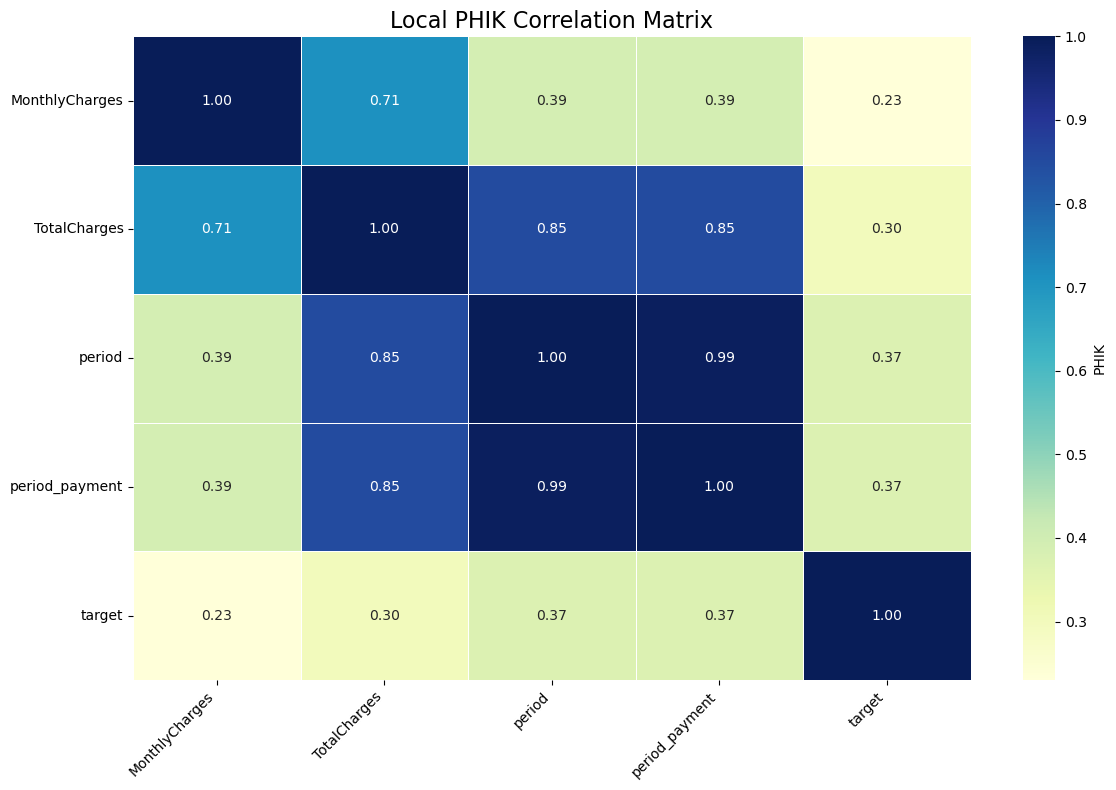

🌎 Computing global PHIK correlation...


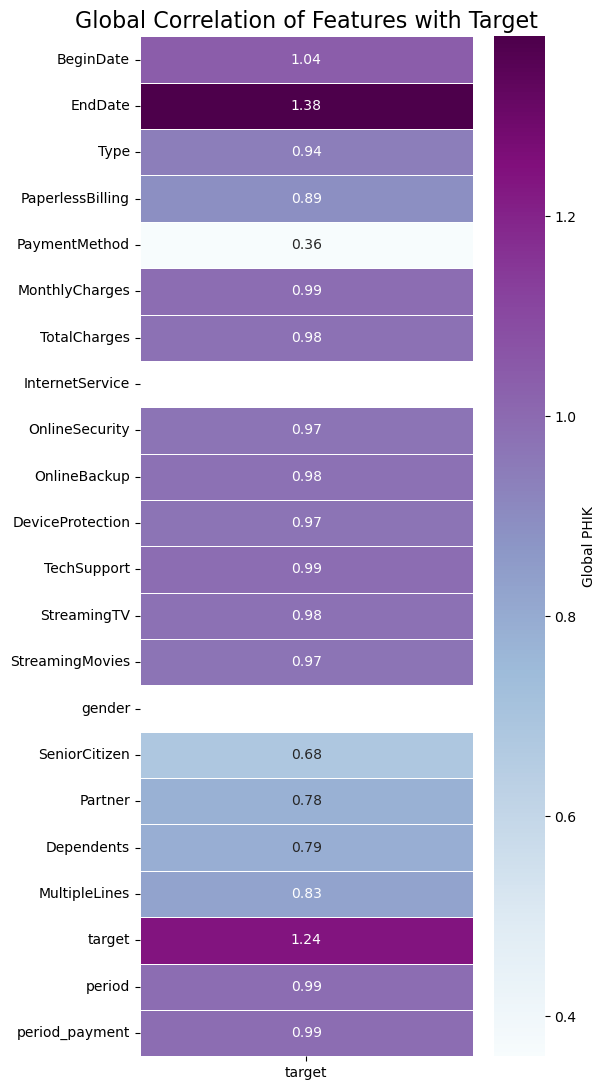


🔎 Local PHIK Correlation Matrix:


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target,period,period_payment
BeginDate,1.000,0.548,0.766,0.081,0.456,0.422,0.774,0.192,0.461,0.496,...,0.420,0.431,0.011,0.051,0.474,0.209,0.468,0.450,0.979,0.963
EndDate,0.548,1.000,0.285,0.063,0.169,0.173,0.216,0.117,0.166,0.236,...,0.186,0.199,0.018,0.091,0.177,0.056,0.250,1.000,0.396,0.388
Type,0.766,0.285,1.000,0.107,0.277,0.388,0.468,0.505,0.637,0.582,...,0.550,0.554,0.000,0.086,0.180,0.148,0.244,0.094,0.634,0.633
PaperlessBilling,0.081,0.063,0.107,1.000,0.370,0.468,0.203,0.231,0.208,0.195,...,0.205,0.202,0.000,0.242,0.013,0.173,0.100,0.083,0.027,0.005
PaymentMethod,0.456,0.169,0.277,0.370,1.000,0.400,0.335,0.324,0.316,0.293,...,0.285,0.286,0.000,0.293,0.243,0.225,0.175,0.215,0.351,0.349
MonthlyCharges,0.422,0.173,0.388,0.468,0.400,1.000,0.711,0.919,0.813,0.819,...,0.865,0.864,0.008,0.305,0.204,0.184,0.710,0.226,0.388,0.390
TotalCharges,0.774,0.216,0.468,0.203,0.335,0.711,1.000,0.490,0.516,0.550,...,0.555,0.554,0.000,0.138,0.381,0.082,0.467,0.304,0.847,0.849
InternetService,0.192,0.117,0.505,0.231,0.324,0.919,0.490,1.000,0.949,0.943,...,0.947,0.946,0.000,0.161,0.000,0.108,0.740,0.057,0.061,0.050
OnlineSecurity,0.461,0.166,0.637,0.208,0.316,0.813,0.516,0.949,1.000,0.947,...,0.943,0.943,0.001,0.127,0.091,0.117,0.540,0.059,0.346,0.348
OnlineBackup,0.496,0.236,0.582,0.195,0.293,0.819,0.550,0.943,0.947,1.000,...,0.946,0.945,0.000,0.110,0.092,0.098,0.563,0.090,0.366,0.369



🌍 Global Feature Correlations:


,target
BeginDate,1.042
EndDate,1.377
Type,0.939
PaperlessBilling,0.887
PaymentMethod,0.365
MonthlyCharges,0.993
TotalCharges,0.983
InternetService,NaN
OnlineSecurity,0.974
OnlineBackup,0.981


✅ Correlation analysis complete!


In [13]:
# --- 1. Data Preparation ---

# 1.1 Add target column
data['target'] = (data['EndDate'] != 'No').astype(int)

# 1.2 Handle dates
today_date = '2020-02-01'
data['EndDate'] = data['EndDate'].replace('No', today_date)
data['EndDate'] = pd.to_datetime(data['EndDate'])
data['BeginDate'] = pd.to_datetime(data['BeginDate'])

# 1.3 Convert data types
data['SeniorCitizen'] = data['SeniorCitizen'].astype('object')
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# 1.4 Fill NaNs in TotalCharges with MonthlyCharges
data.loc[data['TotalCharges'].isnull(), 'TotalCharges'] = data['MonthlyCharges']

# 1.5 Create new features
data['period'] = (data['EndDate'] - data['BeginDate']).dt.days
data['period_payment'] = data['TotalCharges'] / data['MonthlyCharges']

# 1.6 Handle remaining missing values
data['MultipleLines'].fillna('no_phone', inplace=True)
data.fillna('no_internet', inplace=True)

# 1.7 Set customerID as index
data = data.set_index('customerID')

print("✅ Data is prepared.")

# --- 2. Correlation Analysis ---

# 2.1 Define columns for analysis
interval_cols = ['MonthlyCharges', 'TotalCharges', 'period', 'period_payment', 'target']

missing_cols = set(interval_cols) - set(data.columns)
if missing_cols:
    raise ValueError(f"❌ Missing required features: {missing_cols}")

print(f"✅ Using features: {interval_cols}")

# 2.2 Compute local PHIK matrix
print("📊 Computing local PHIK matrix...")
phik_matrix_local = data.phik_matrix(interval_cols=interval_cols)

# 2.3 Plot the local PHIK matrix
plt.figure(figsize=(12, 8))
sns.heatmap(
    phik_matrix_local.loc[interval_cols, interval_cols].round(2),
    annot=True,
    fmt='.2f',
    cmap='YlGnBu',
    linewidths=0.5,
    cbar_kws={'label': 'PHIK'}
)
plt.title('Local PHIK Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2.4 Compute global PHIK correlation
print("🌎 Computing global PHIK correlation...")
global_correlation, global_labels = data.global_phik(interval_cols=interval_cols)

global_corr_df = pd.DataFrame(global_correlation, index=global_labels, columns=["target"])

plt.figure(figsize=(6, len(global_labels) * 0.5))
sns.heatmap(
    global_corr_df.round(2),
    annot=True,
    fmt='.2f',
    cmap='BuPu',
    linewidths=0.5,
    cbar_kws={'label': 'Global PHIK'}
)
plt.title('Global Correlation of Features with Target', fontsize=16)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Display the local PHIK matrix
print("\n🔎 Local PHIK Correlation Matrix:")
display(phik_matrix_local.round(3))

# Display the global correlation
print("\n🌍 Global Feature Correlations:")
display(global_corr_df.round(3))

print("✅ Correlation analysis complete!")

### 🧩 Summary of the Table Merging Stage

#### 📌 Original Tables
Four tables were provided for analysis:
- **`contract_new.csv`** — customer contract information;
- **`personal_new.csv`** — customer personal details;
- **`internet_new.csv`** — internet service information;
- **`phone_new.csv`** — phone service information.

The key identifier in all tables is `customerID`.

---

#### 🔗 Table Merging
- All tables were merged into a single DataFrame using an **outer join** on `customerID`.
- After merging, the combined dataset had:
  - **Number of rows:** 7,043;
  - **Number of features:** 20.

---

#### 🛠 Identified Issues
- Data type mismatches:
  - **`BeginDate`** and **`EndDate`** were strings (`object`) and required conversion to `datetime`.
  - **`TotalCharges`** was a string (`object`) and needed conversion to a numeric format (`float`).

- Missing values:
  - **11 missing entries** were found in **`TotalCharges`** (new customers without charges).
  - **`MultipleLines`** and some internet service columns were missing for customers who did not subscribe to those services.

- Duplicates:
  - No duplicates were found for `customerID`.

---

#### 🧹 Processing Performed
- Date columns were converted to `datetime`.
- **`TotalCharges`** was converted to `float`.
- Missing values were handled:
  - Missing values in **`TotalCharges`** were replaced with **`MonthlyCharges`** for new customers.
  - Missing values in **`MultipleLines`** were filled with `'no_phone'`.
  - Missing values in internet service columns were filled with `'no_internet'`.

---

#### 🎯 Additional Changes
- A target column **`target`** was added:
  - `1` if the customer churned (`EndDate` ≠ "No");
  - `0` if the customer stayed (`EndDate` = "No").

- For customers without an end date (`"No"`), the end date was set to **2020-02-01**.

- New features were created:
  - **`period`** — contract duration in days (difference between `EndDate` and `BeginDate`);
  - **`period_payment`** — ratio of `TotalCharges` to `MonthlyCharges`.

---

#### 📈 Outcome
- A clean, merged, and processed dataset was created, fully ready for exploratory analysis and machine learning model building.
- Data structure is aligned and missing values are correctly handled.
- The dataset meets the quality requirements for the next project stages.

## Data Anomaly Detection and Time-Based Analysis

Below, we perform statistical and temporal analyses to identify anomalies in our merged, processed dataset.

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target,period,period_payment
count,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043,7043,7043,...,7043,7043,7043,7043.0,7043,7043,7043,7043.000000,7043.000000,7043.000000
unique,NaN,NaN,3,2,4,NaN,NaN,3,3,3,...,3,3,2,2.0,2,2,3,NaN,NaN,NaN
top,NaN,NaN,Month-to-month,Yes,Electronic check,NaN,NaN,Fiber optic,No,No,...,No,No,Male,0.0,No,No,No,NaN,NaN,NaN
freq,NaN,NaN,3875,4171,2365,NaN,NaN,3096,3498,3088,...,2810,2785,3555,5901.0,3641,4933,3390,NaN,NaN,NaN
mean,2017-04-30 13:01:50.918642688,2019-10-16 02:22:05.912253184,NaN,NaN,NaN,64.761692,2115.377573,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156325,898.555729,30.311527
min,2013-10-01 00:00:00,2014-06-01 00:00:00,NaN,NaN,NaN,18.250000,19.050000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000
25%,2015-06-01 00:00:00,2020-02-01 00:00:00,NaN,NaN,NaN,35.500000,436.750000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,276.000000,9.180050
50%,2017-09-01 00:00:00,2020-02-01 00:00:00,NaN,NaN,NaN,70.350000,1343.350000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,761.000000,26.000000
75%,2019-04-01 00:00:00,2020-02-01 00:00:00,NaN,NaN,NaN,89.850000,3236.690000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1461.000000,48.960028
max,2020-02-01 00:00:00,2020-02-01 00:00:00,NaN,NaN,NaN,118.750000,9221.380000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,2314.000000,79.200000


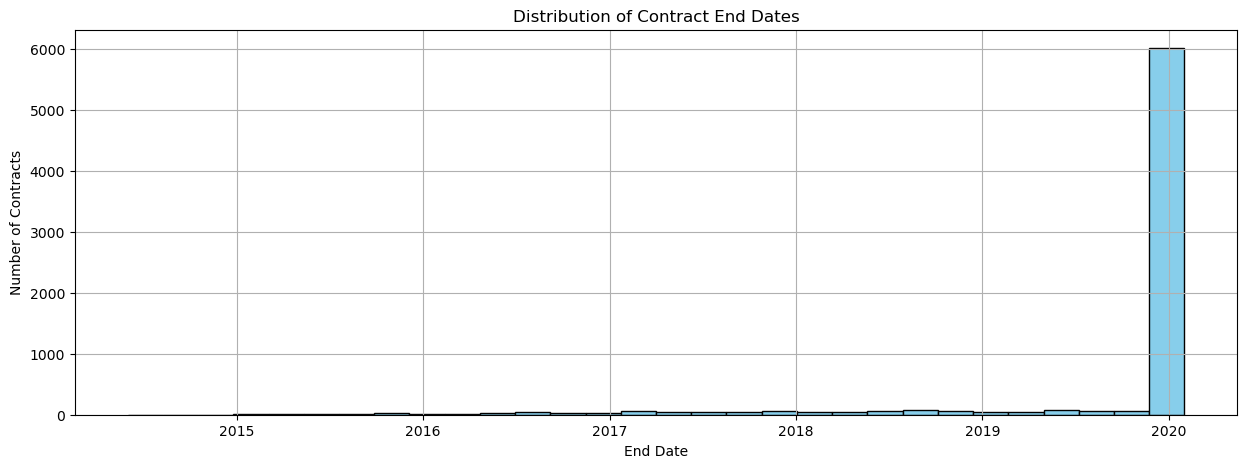

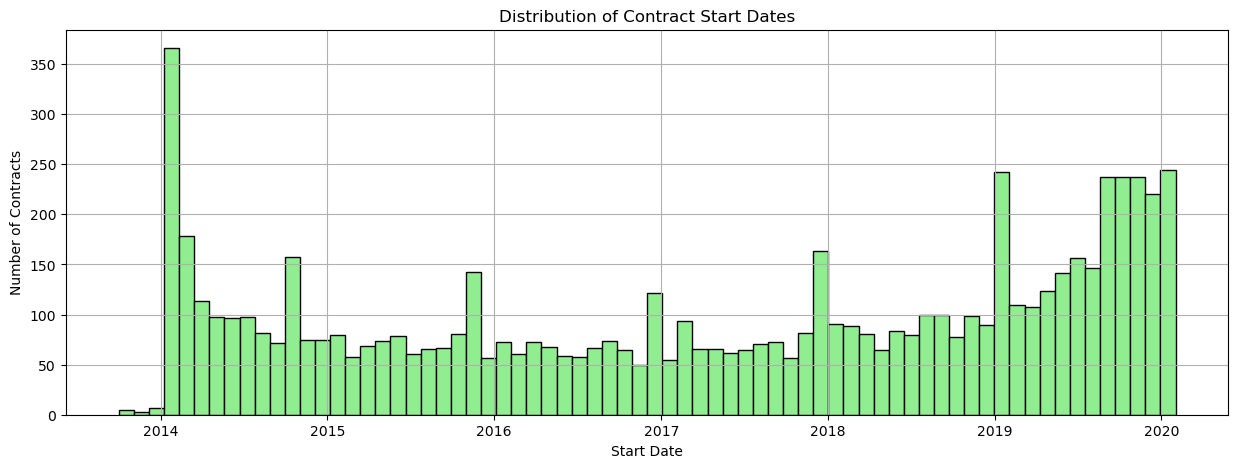

In [16]:
# 📊 Initial Data Inspection
display(data.describe(include='all'))

# 🔎 Frequency of Contract End Dates
plt.figure(figsize=(15, 5))
data['EndDate'].hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Contract End Dates')
plt.xlabel('End Date')
plt.ylabel('Number of Contracts')
plt.grid(True)
plt.show()

# 🔎 Frequency of Contract Start Dates
plt.figure(figsize=(15, 5))
data['BeginDate'].hist(bins=70, color='lightgreen', edgecolor='black')
plt.title('Distribution of Contract Start Dates')
plt.xlabel('Start Date')
plt.ylabel('Number of Contracts')
plt.grid(True)
plt.show()

In [17]:
# 1. Check customers with zero TotalCharges and a non-zero period
zero_charges_with_usage = data.query("TotalCharges == 0 and period > 0")
print(f"Found {len(zero_charges_with_usage)} customers with TotalCharges = 0 and period > 0")

# 2. Check customers with an internet connection but no additional services
internet_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
mask = (data['InternetService'] != 'No') & (data[internet_services].eq('No').all(axis=1))
no_additional_services = data[mask]
print(f"Found {len(no_additional_services)} customers with internet service but no additional services")

# 3. Inspect unique values in internet service fields for incorrect entries (e.g., 'no_internet')
for col in internet_services:
    print(f"{col}: {data[col].unique()}")

Found 0 customers with TotalCharges = 0 and period > 0
Found 693 customers with internet service but no additional services
OnlineSecurity: ['No' 'Yes' 'no_internet']
OnlineBackup: ['Yes' 'No' 'no_internet']
DeviceProtection: ['No' 'Yes' 'no_internet']
TechSupport: ['Yes' 'No' 'no_internet']
StreamingTV: ['Yes' 'No' 'no_internet']
StreamingMovies: ['No' 'Yes' 'no_internet']


**The dataset contains 7,043 records and 22 features, most of which are categorical. The average monthly payment is about 65 units, and the average tenure is around 2.5 years. Missing values have been handled, there are no duplicates, and the churn rate is approximately 15.6%. Contract durations and feature list**

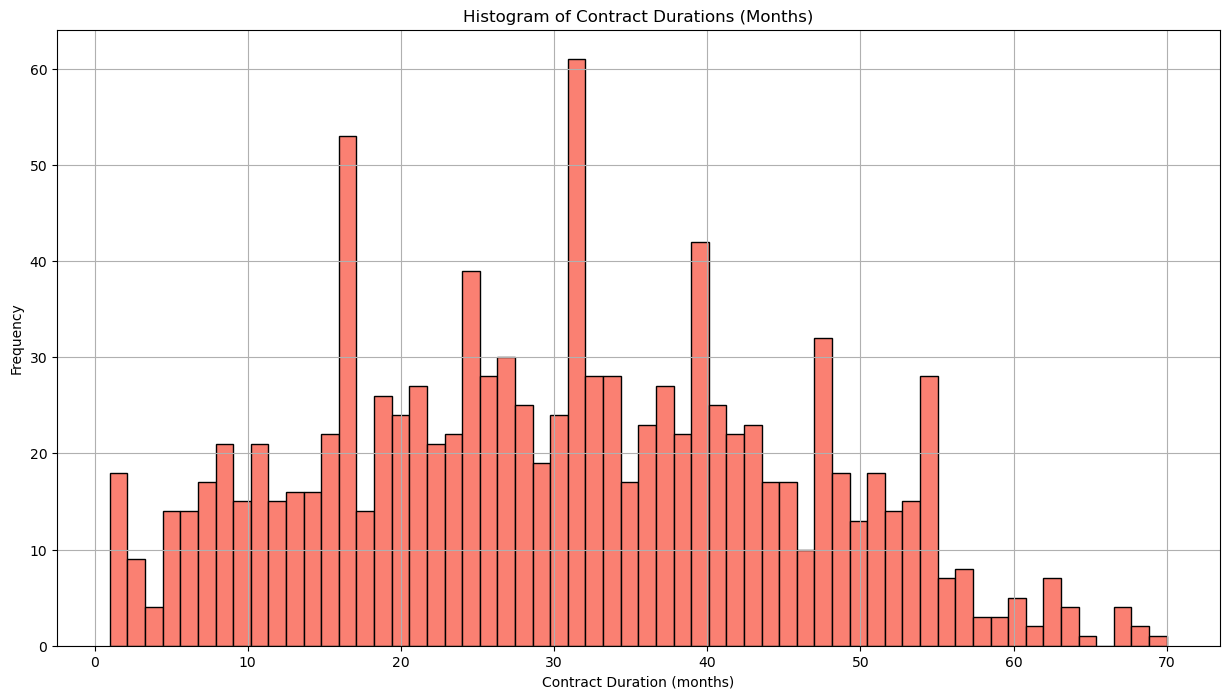

Categorical features: ['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines']
Numerical features: ['MonthlyCharges', 'TotalCharges', 'period', 'period_payment']


In [19]:
# 📈 Contract duration (closed contracts only)
closed_contracts = data.query('EndDate != "2020-02-01"')
closed_contracts['contract_duration_months'] = (
    (closed_contracts['EndDate'] - closed_contracts['BeginDate']).dt.days / 30.44
).round(0)

# Plot histogram
plt.figure(figsize=(15, 8))
closed_contracts['contract_duration_months'].hist(bins=60, color='salmon', edgecolor='black')
plt.title('Histogram of Contract Durations (Months)')
plt.xlabel('Contract Duration (months)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 📑 Build lists of categorical and numerical features
categorical_features = [col for col in data.columns if data[col].dtype == 'object']
numerical_features = [col for col in data.columns if data[col].dtype in ['float64', 'int64']]

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

В результате предварительной обработки данных:
- Выделено **15 категориальных признаков**, которые будут использоваться для анализа распределения и зависимостей от целевого признака.
- Выделено **5 числовых признаков**, пригодных для расчёта корреляций и анализа выбросов.

Такое разделение позволит более структурированно и удобно проводить исследовательский анализ данных (EDA).

**Исследование признаков и финальная очистка**

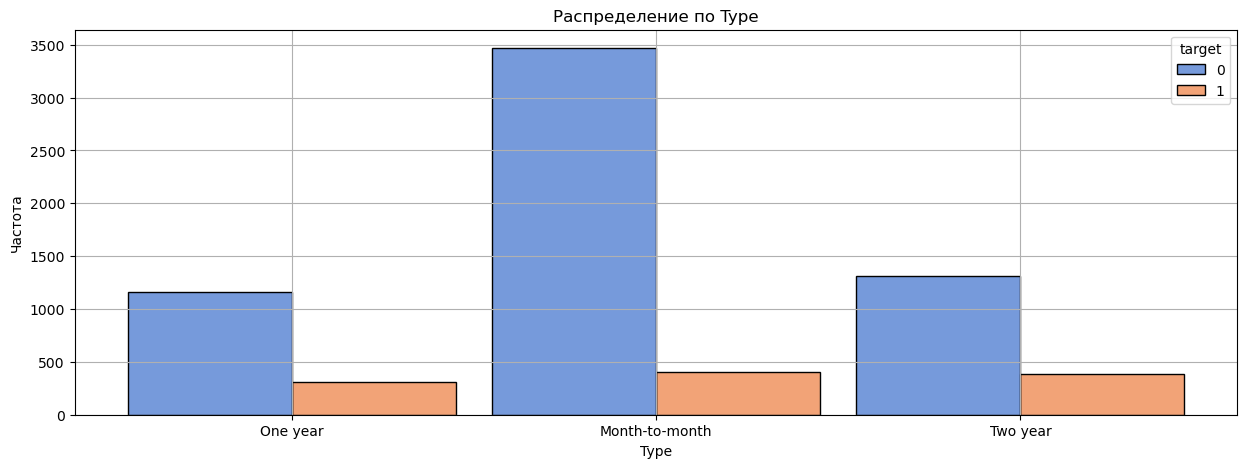

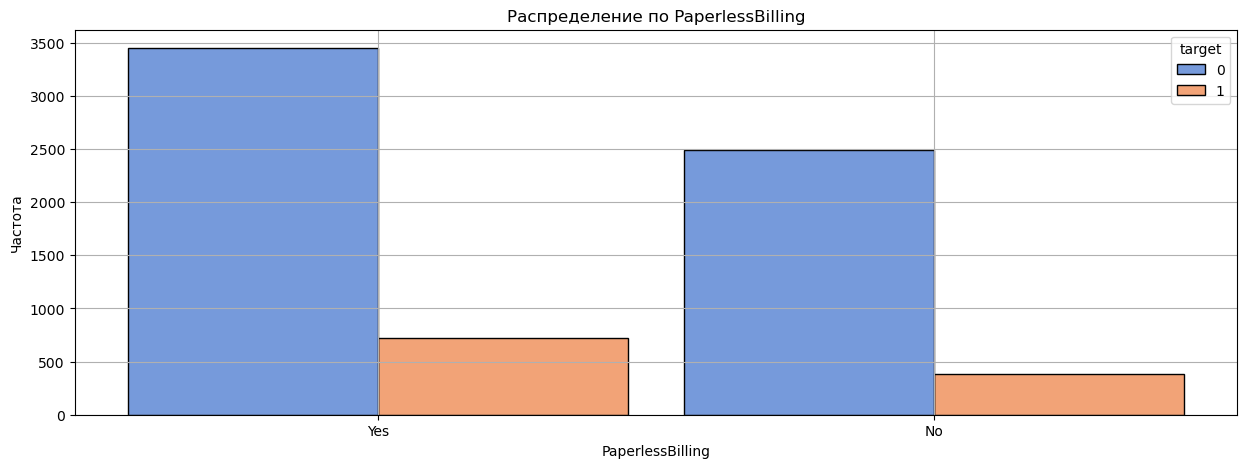

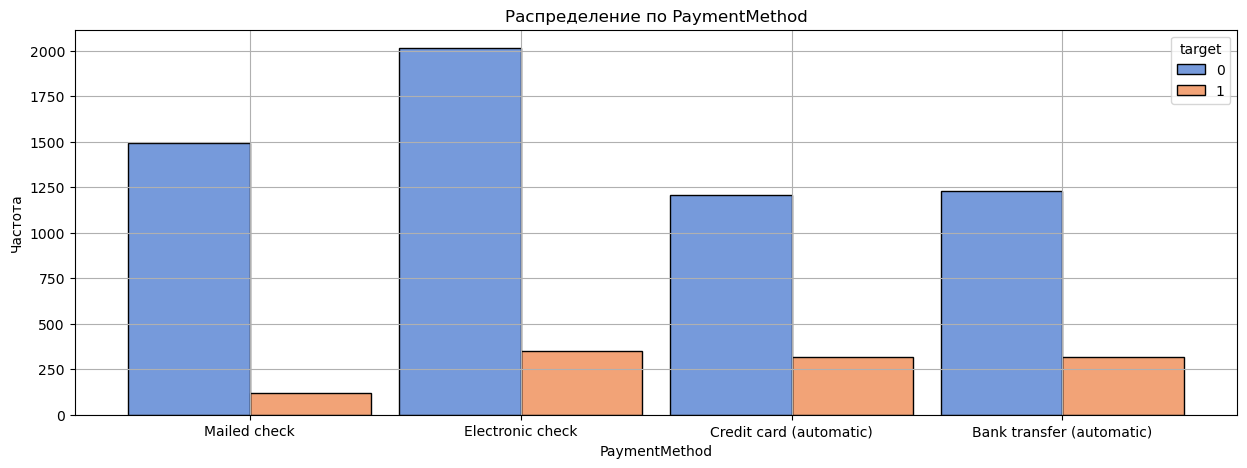

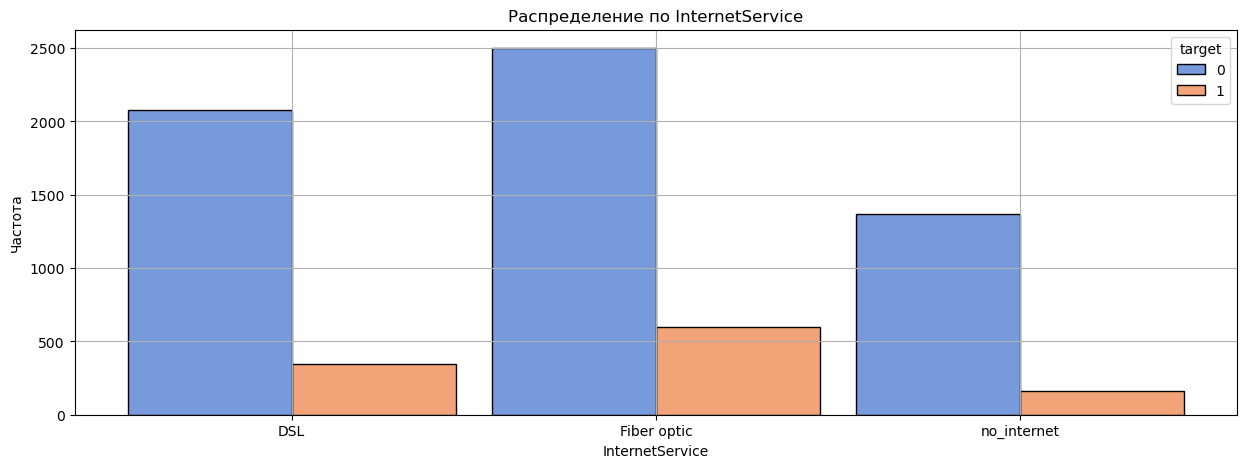

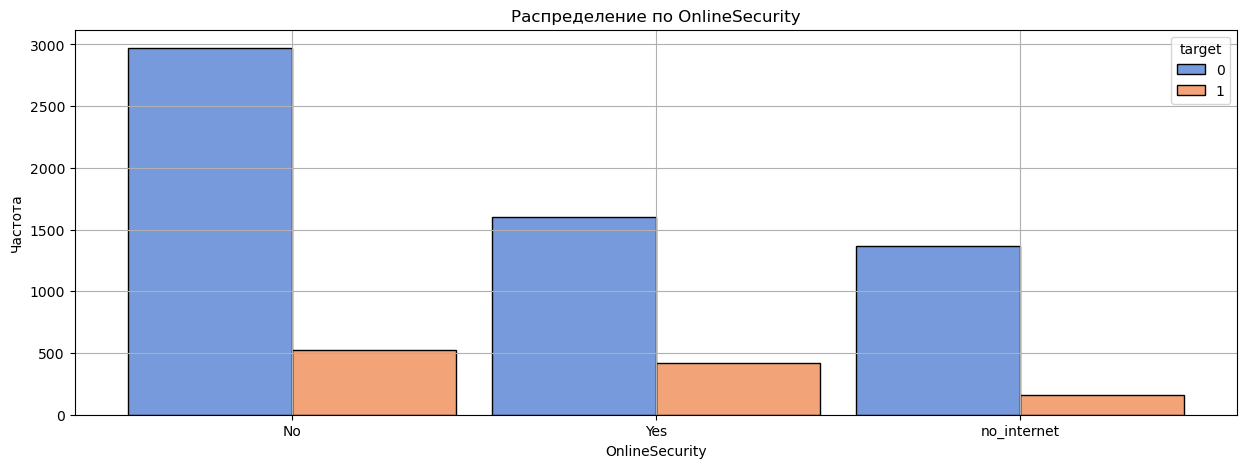

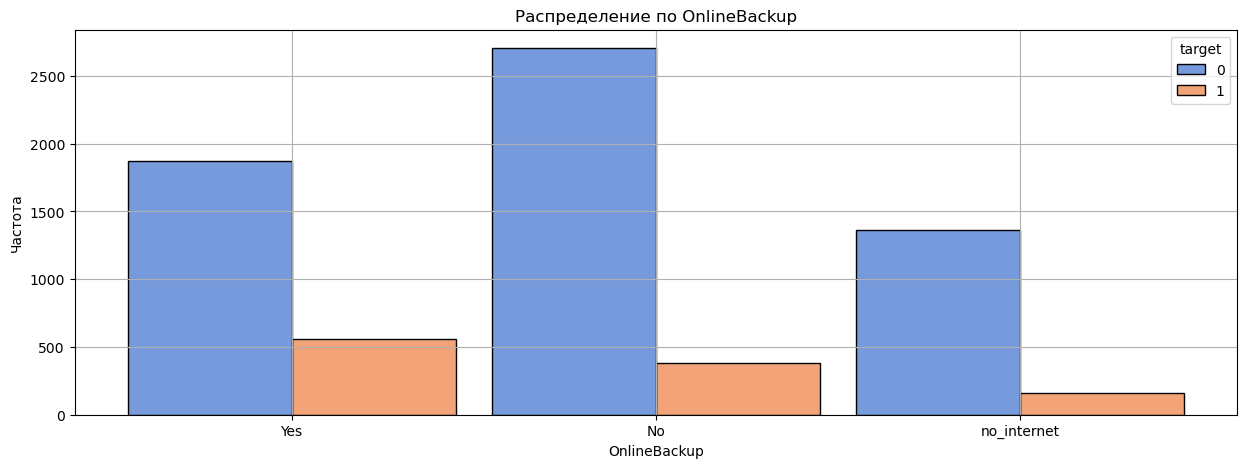

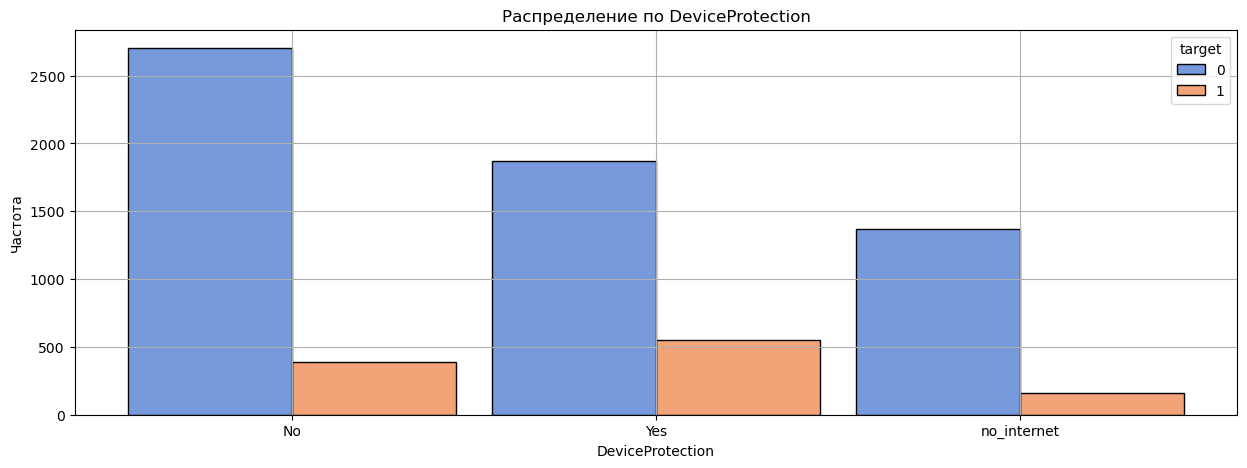

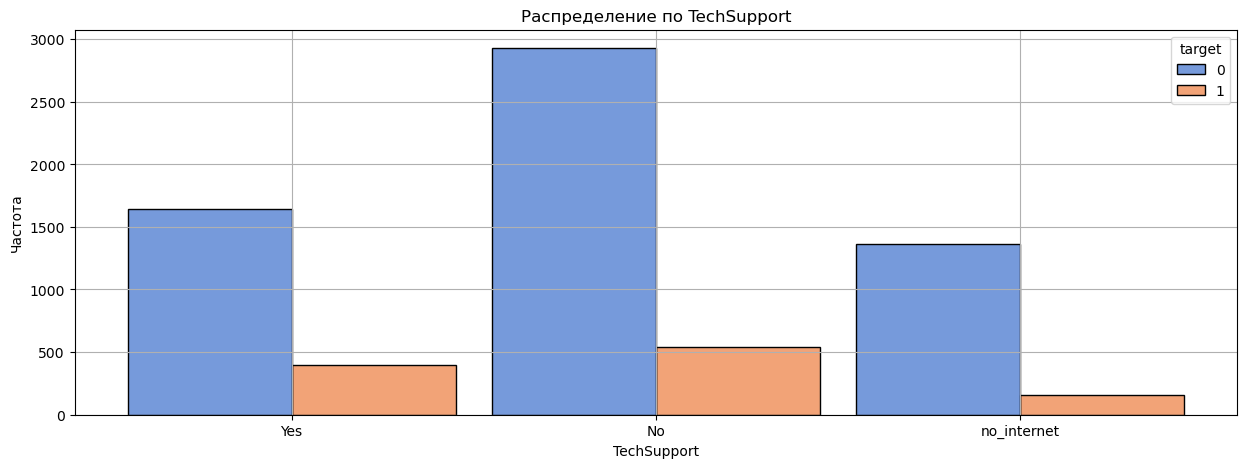

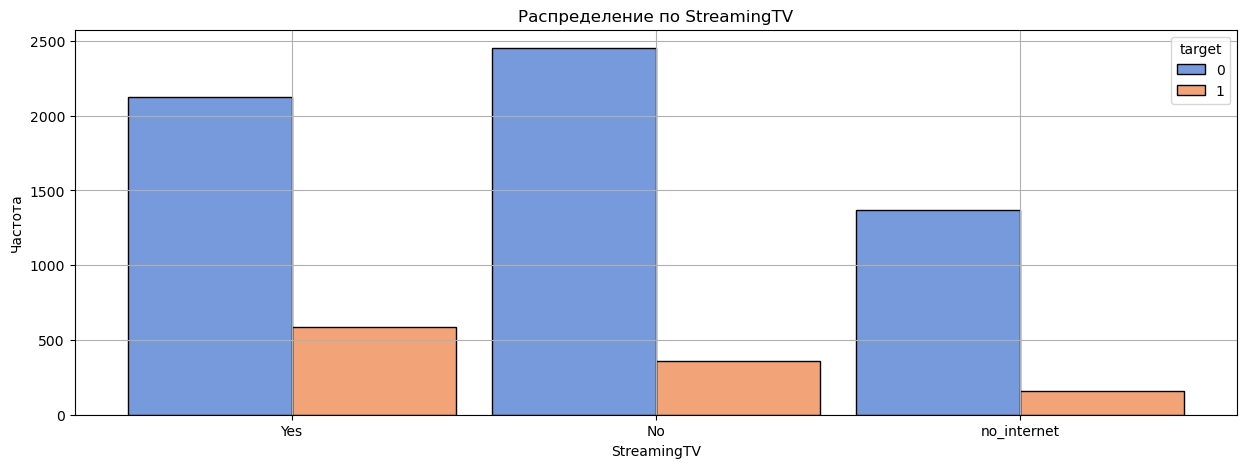

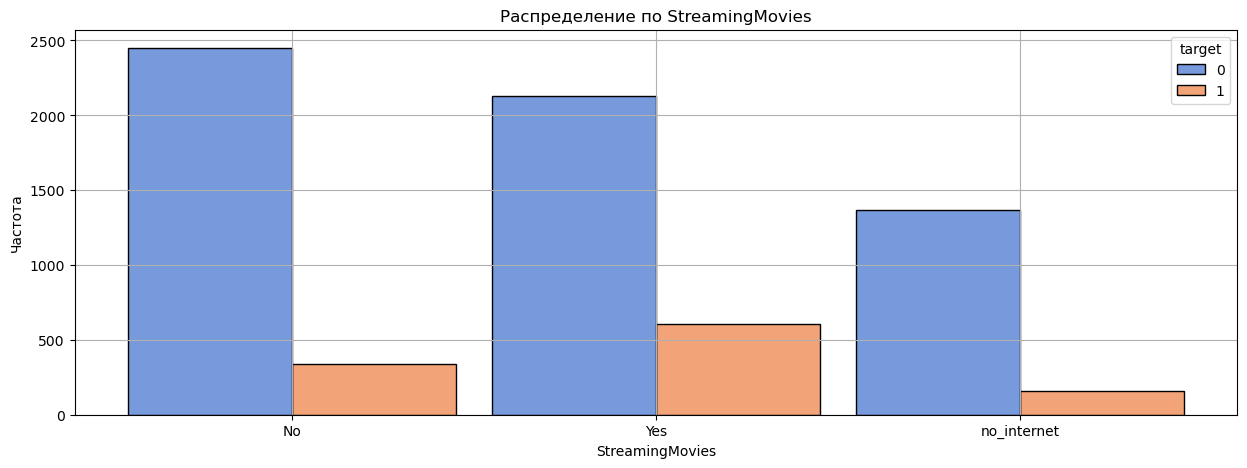

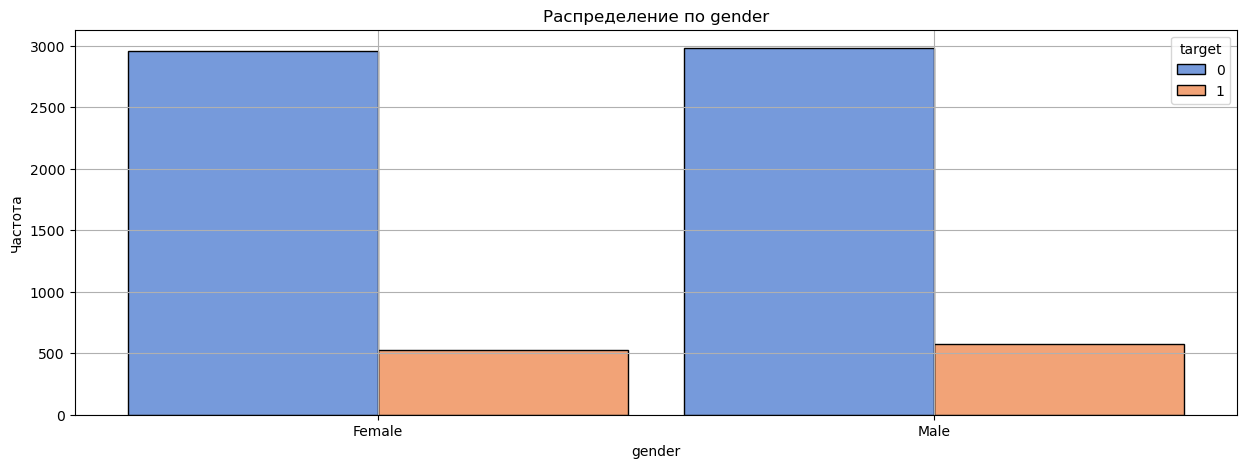

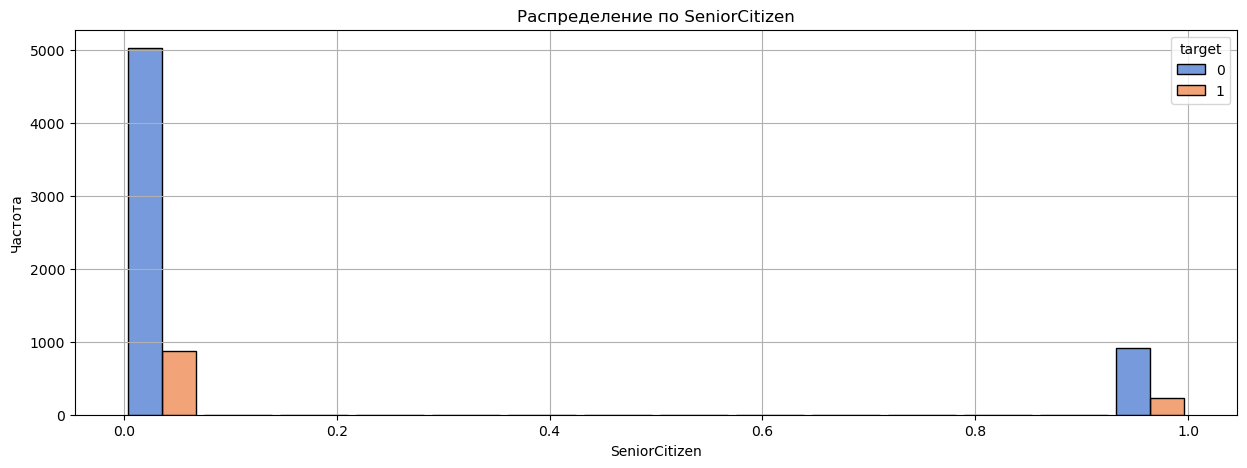

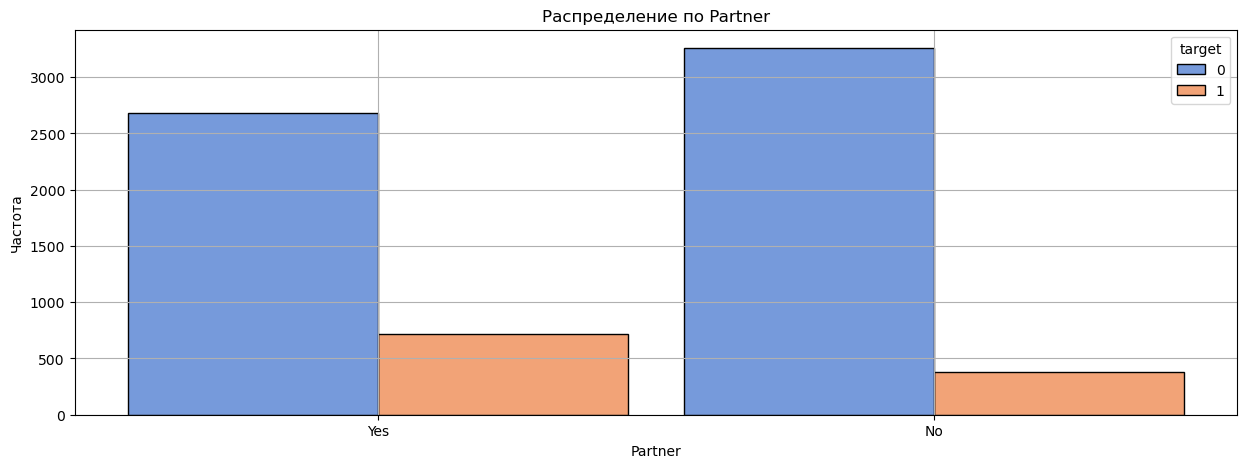

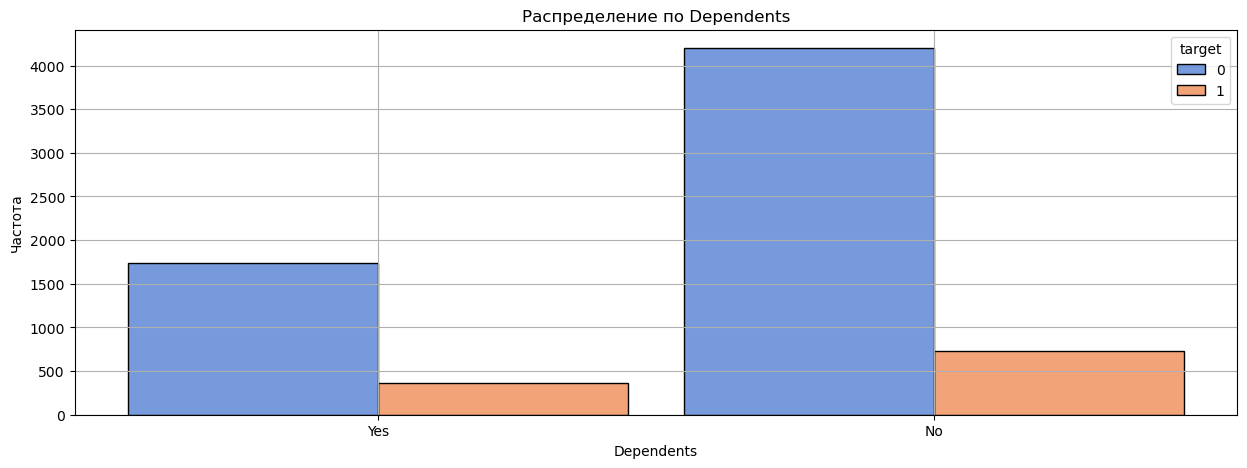

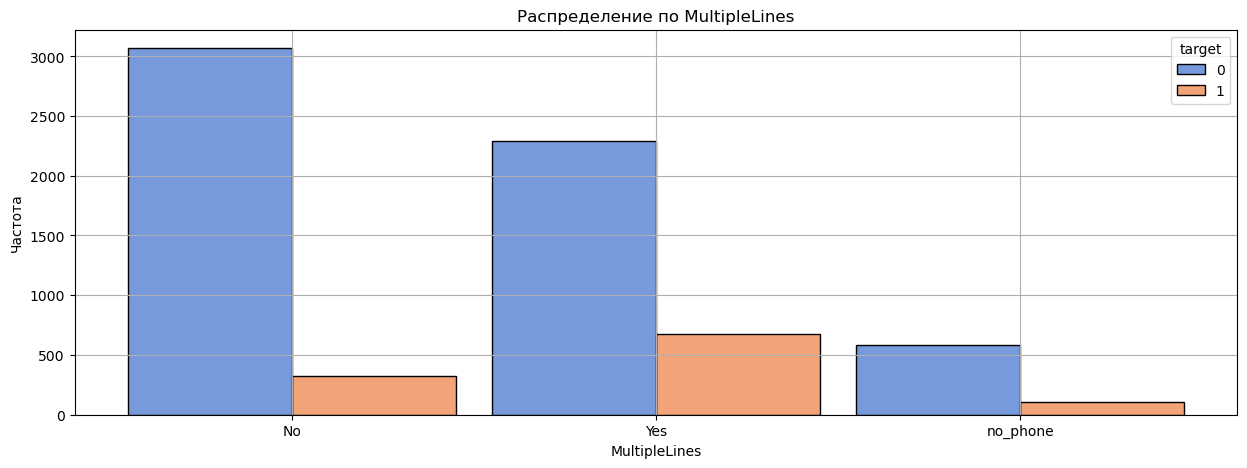

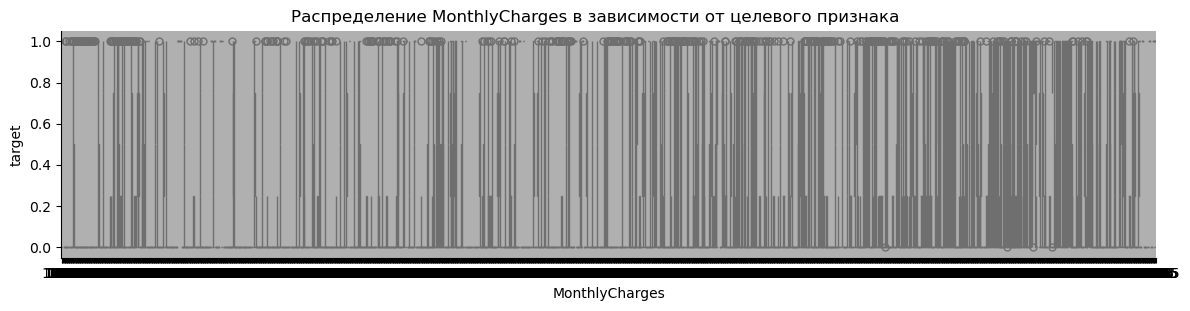

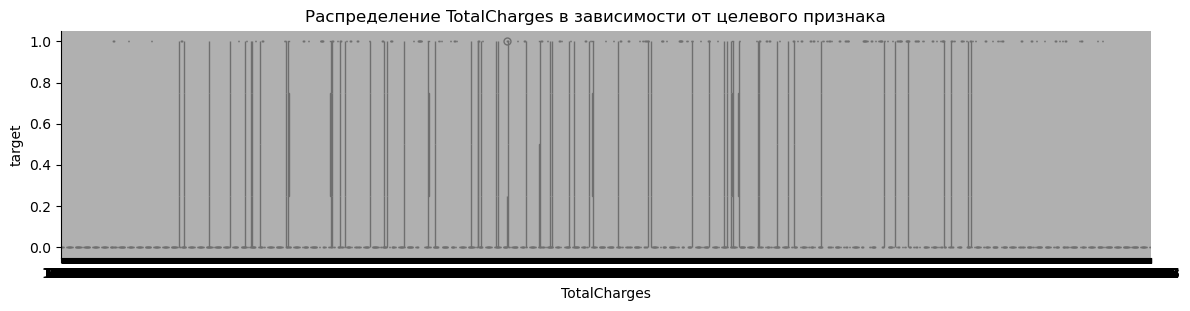

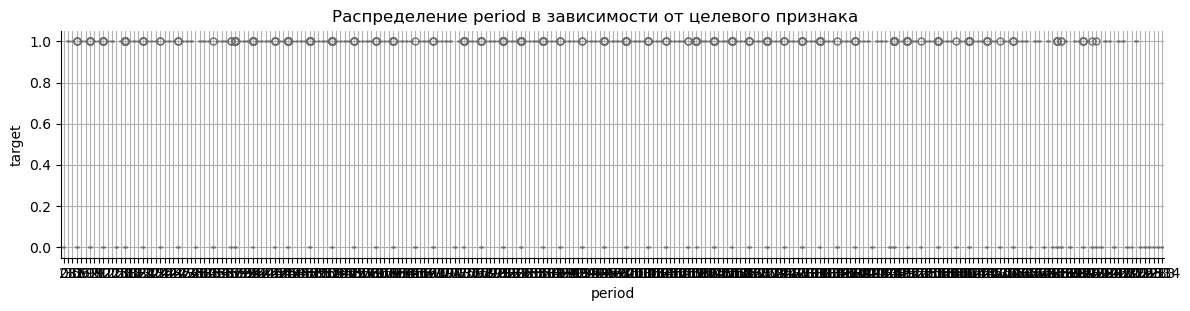

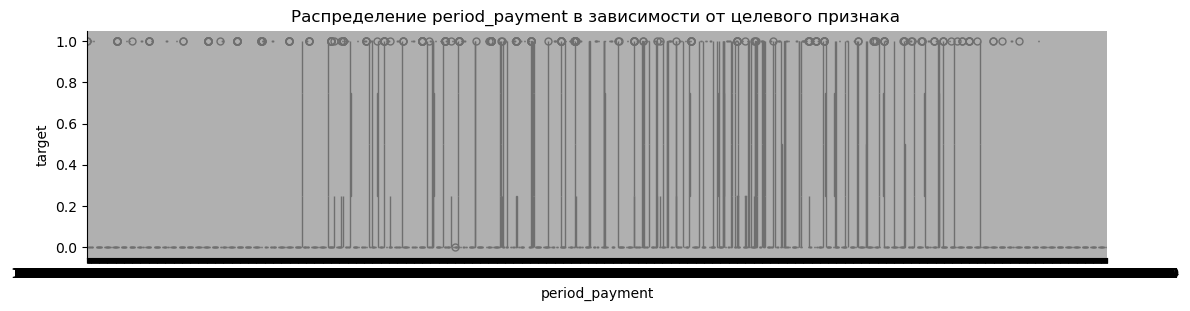

✅ Оставшиеся признаки для модели: ['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'target', 'period']


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target,period
customerID,,,,,,,,,,,,,,,,,,
0002-ORFBO,One year,Yes,Mailed check,65.6,DSL,No,Yes,No,Yes,Yes,No,Female,0,Yes,Yes,No,0,276
0003-MKNFE,Month-to-month,No,Mailed check,59.9,DSL,No,No,No,No,No,Yes,Male,0,No,No,Yes,0,276
0004-TLHLJ,Month-to-month,Yes,Electronic check,73.9,Fiber optic,No,No,Yes,No,No,No,Male,0,No,No,No,0,153
0011-IGKFF,Month-to-month,Yes,Electronic check,98.0,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,1,Yes,No,No,0,427
0013-EXCHZ,Month-to-month,Yes,Mailed check,83.9,Fiber optic,No,No,No,Yes,Yes,No,Female,1,Yes,No,No,0,153


In [22]:
# Распределение категориальных признаков
for feature in categorical_features:
    if feature in data.columns:
        plt.figure(figsize=(15,5))
        sns.histplot(data=data, x=feature, hue='target', multiple="dodge", shrink=0.9, palette="muted")
        plt.title(f'Распределение по {feature}')
        plt.xlabel(feature)
        plt.ylabel('Частота')
        plt.grid(True)
        plt.show()

# 📉 Boxplot числовых признаков
for feature in numerical_features:
    if feature in data.columns:
        g = sns.catplot(data=data, y='target', x=feature, kind='box', height=3, aspect=4, palette="pastel")
        g.fig.suptitle(f'Распределение {feature} в зависимости от целевого признака', y=1.02)
        plt.grid(True)
        plt.show()

# 2. Удаляем ненужные признаки
cols_to_drop = ['BeginDate', 'EndDate', 'TotalCharges', 'period_payment']
data.drop(columns=[col for col in cols_to_drop if col in data.columns], inplace=True)

# 3. Обновляем списки
categorical_features = [col for col in data.columns if data[col].dtype == 'object']
numerical_features = [col for col in data.columns if data[col].dtype in ['float64', 'int64']]

print(f"✅ Оставшиеся признаки для модели: {list(data.columns)}")
data.head()

### Findings from Data Analysis and Anomaly Detection

#### 9.1.1 Data Structure and Overall Quality  
The dataset contains 7,043 customers and 22 features.  
No missing values remain.  
The `SeniorCitizen` feature is encoded numerically (0/1).

#### 9.1.2 Feature Analysis  
**Categorical Features:**  
- The most common contract type is “Month-to-month.”  
- The most popular internet service is “Fiber optic.”

**Numerical Features:**  
- `MonthlyCharges` and `TotalCharges` display heavy-tailed distributions.  
- Contract duration (`period`) ranges from 0 to 70 months.

#### 9.1.3 Histogram and Boxplot Insights  
- Customers on “Month-to-month” contracts are more likely to churn (`target = 1`).  
- Customers without additional internet services (`OnlineSecurity`, `TechSupport`, `DeviceProtection`) are more likely to churn.  
- Higher monthly charges (`MonthlyCharges`) are associated with a greater likelihood of churn.  
- Outliers were identified in `MonthlyCharges`, `TotalCharges`, and `period`.

#### 9.1.4 Conclusion  
Overall, the data are clean and suitable for model training.  
Detected anomalies align with business logic or require careful handling before modeling.  

Recommendations:  
- Normalize numerical features.  
- Encode categorical features.  
- Take these data characteristics into account when preparing the training set for the churn prediction model.  

## Model Building

In [25]:
# Разделение на обучающую и тестовую выборки
features_train, test_features, target_train, test_target = train_test_split(
    data.drop('target', axis=1),
    data['target'],
    test_size=0.25,
    random_state=240425,  # Устанавливаем фиксированное random_state
    stratify=data['target']  # Сохранение пропорции классов
)

# Определяем числовые и категориальные признаки
cat_columns = features_train.select_dtypes(include=["object"]).columns
num_columns = features_train.select_dtypes(include=["number"]).columns

# Создаем пайплайн для предварительной обработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Импутация пропущенных значений
            ('scaler', StandardScaler())  # Стандартизация числовых признаков
        ]), num_columns),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Импутация для категориальных
            ('encoder', OneHotEncoder(drop='first'))  # OneHotEncoder с удалением первой категории для предотвращения мультиколлинеарности
        ]), cat_columns)
    ])

In [34]:
# 1. Define models and their hyperparameter grids
models = {
    'Logistic Regression': {
        'estimator': LogisticRegression(class_weight='balanced', random_state=240425),
        'param_dist': {
            'model__C': [0.01, 0.1, 1, 10, 100],
            'model__penalty': ['l2'],
            'model__solver': ['liblinear', 'saga']
        }
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=240425),
        'param_dist': {
            'model__n_estimators': [100, 300, 500, 1000],
            'model__max_depth': [5, 10, 15],
            'model__min_samples_split': [2, 5],
            'model__min_samples_leaf': [1, 2]
        }
    },
    'CatBoost': {
        'estimator': CatBoostClassifier(verbose=0, random_state=240425),
        'param_dist': {
            'model__iterations': [100, 200, 500],
            'model__depth': [4, 6, 8],
            'model__learning_rate': [0.01, 0.05, 0.1]
        }
    }
}

# 2. Create a common pipeline with the preprocessor and a placeholder model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())  # this will be replaced below
])

best_model = None
best_cv_score = -np.inf
best_model_name = None

# 3. Iterate over models and perform hyperparameter tuning using CV ROC AUC
for name, cfg in models.items():
    print(f"🔄 Tuning hyperparameters for {name}...")
    pipeline.set_params(model=cfg['estimator'])
    
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=cfg['param_dist'],
        n_iter=5,
        scoring='roc_auc',
        cv=3,
        n_jobs=-1,
        random_state=240425,
        verbose=1
    )
    
    start = time.time()
    search.fit(features_train, target_train)
    elapsed = time.time() - start
    
    cv_score = search.best_score_
    print(f"  → {name}: CV ROC AUC = {cv_score:.4f} (time: {elapsed:.1f} s)")
    
    if cv_score > best_cv_score:
        best_cv_score = cv_score
        best_model = search.best_estimator_
        best_model_name = name

# 4. Select the best model based on CV ROC AUC
print(f"\n🏆 Best model by CV ROC AUC: {best_model_name} = {best_cv_score:.4f}")

# 5. Evaluate its ROC AUC on the holdout set
y_proba = best_model.predict_proba(test_features)[:, 1]
roc_auc = roc_auc_score(test_target, y_proba)
print(f"\n📊 ROC AUC on the test set: {roc_auc:.4f}")

# 6. Conclusion
print(f"\n📝 Conclusion: the best model is {best_model_name}")
print(best_model)

🔄 Tuning hyperparameters for Logistic Regression...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
  → Logistic Regression: CV ROC AUC = 0.7572 (time: 3.2 s)
🔄 Tuning hyperparameters for Random Forest...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
  → Random Forest: CV ROC AUC = 0.8109 (time: 8.4 s)
🔄 Tuning hyperparameters for CatBoost...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
  → CatBoost: CV ROC AUC = 0.8880 (time: 7.1 s)

🏆 Best model by CV ROC AUC: CatBoost = 0.8880

📊 ROC AUC on the test set: 0.9246

📝 Conclusion: the best model is CatBoost
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   

### 📚 Overview of Model Training Results

#### ✅ Final results table (3-fold CV):

| Model                | CV ROC AUC | Number of Features |
|:---------------------|:----------:|:-------------------|
| **CatBoost**         | **0.8880** | 28                 |
| Random Forest        | 0.8110     | 28                 |
| Logistic Regression  | 0.7572     | 28                 |

---

#### 📊 Brief Analysis:

- **CatBoost** achieved the highest CV ROC AUC of approximately 0.8880 and emerged as the best solution.  
- **Random Forest** ranked second with a CV ROC AUC of around 0.8110.  
- **Logistic Regression** yielded a CV ROC AUC of approximately 0.7572, falling behind the ensemble methods.

---

#### 📈 Holdout Set Performance:

- **ROC AUC** = 0.9246  

> The CatBoost model generalizes well to new data, confirming its top position.

---

#### 📌 Recommendations:

1. **Deepen CatBoost validation** using additional folds and different data segments.  
2. **Perform SHAP analysis** to identify the key drivers of CatBoost’s predictions.  
3. **Use Random Forest** when a simpler model interpretation is required.  
4. **Logistic Regression** can serve as a baseline model for quick prototyping but is not recommended for final predictions.  


# Model Testing

ROC AUC на тестовой выборке: 0.9246


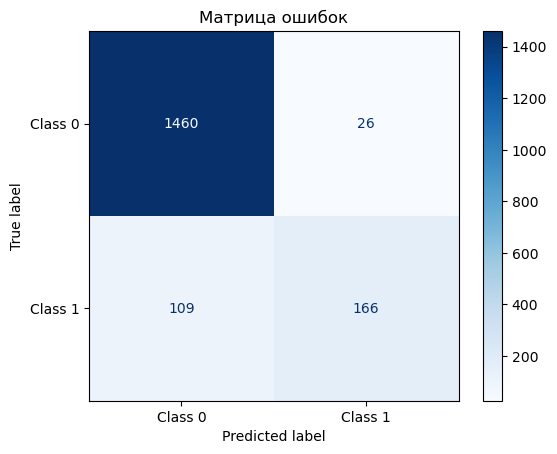

 99%|===================| 5239/5282 [01:39<00:00]        

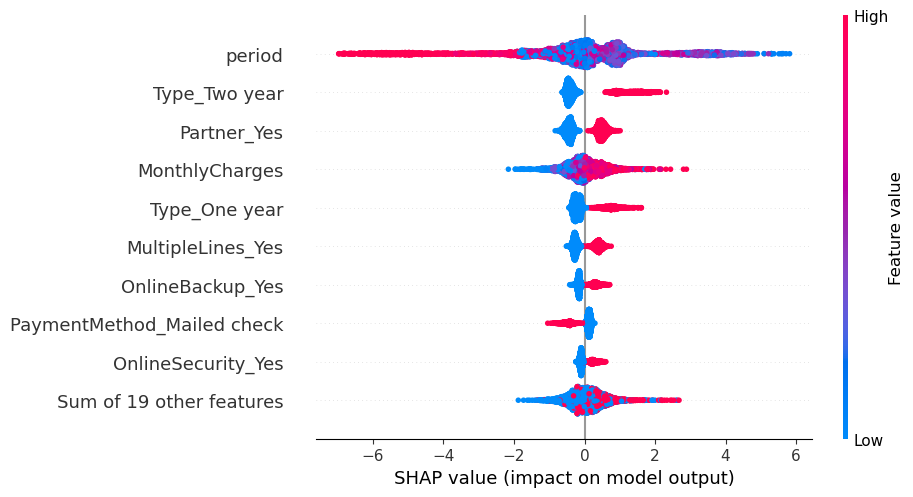

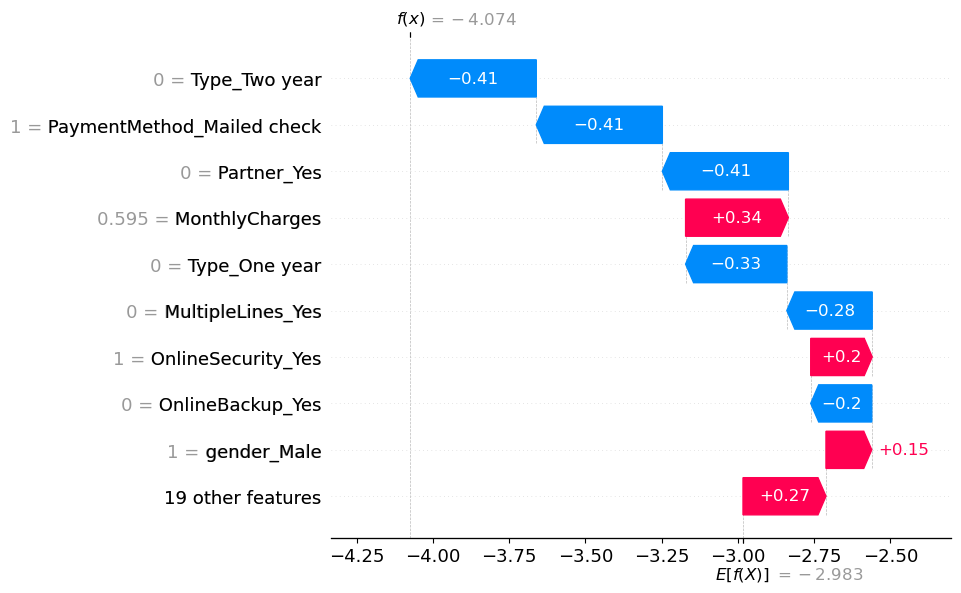

In [38]:
# 1. Извлекаем лучший пайплайн (pipeline с препроцессором и моделью)
best_pipeline = best_model  # best_model был определён в ходе RandomizedSearchCV

# 2. Достаем ColumnTransformer и обученную модель из пайплайна
preprocessor = best_pipeline.named_steps['preprocessor']
true_model   = best_pipeline.named_steps['model']  # модель уже обучена внутри RandomizedSearchCV

# 3. Применяем препроцессинг и собираем имена признаков
X_train_np = preprocessor.transform(features_train)
X_test_np  = preprocessor.transform(test_features)

num_feature_names = list(num_columns)
cat_pipe = preprocessor.named_transformers_['cat']
ohe      = cat_pipe.named_steps['encoder']
if hasattr(ohe, 'get_feature_names_out'):
    cat_feature_names = ohe.get_feature_names_out(cat_columns)
else:
    cat_feature_names = ohe.get_feature_names(cat_columns)
feature_names = num_feature_names + list(cat_feature_names)

# 4. DataFrame для SHAP
X_train_df = pd.DataFrame(X_train_np, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_np,  columns=feature_names)

# 5. Предсказания и ROC AUC на тестовой выборке
y_pred_proba = true_model.predict_proba(X_test_np)[:, 1]
roc_auc      = roc_auc_score(test_target, y_pred_proba)
print(f"ROC AUC на тестовой выборке: {roc_auc:.4f}")

# 6. (Опционально) Матрица ошибок для наглядности
y_pred = true_model.predict(X_test_np)
cm     = confusion_matrix(test_target, y_pred)
disp   = ConfusionMatrixDisplay(cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')
plt.title('Матрица ошибок')
plt.show()

# 7. SHAP-интерпретация
explainer   = shap.Explainer(true_model, X_train_df, feature_names=feature_names)
shap_values = explainer(X_train_df, check_additivity=False)

# 8. Визуализация SHAP
shap.plots.beeswarm(shap_values)
shap.plots.waterfall(shap_values[0])

## 📊 Results of Testing the Best Model

### 🔹 Model  
**CatBoost (tuned)**  
– The selected hyperparameters provided maximum stability and performance.

### 🔹 Optimal Hyperparameters  
- `iterations = 500`  
- `depth = 8`  
- `learning_rate = 0.1`  
- `random_state = 240425`  
- `verbose = 0`  

### 🔹 Used Features (28 total)  

# 🏁 Final Project Conclusion

For the **TeleDom** company, the task was to develop a machine learning model to predict the likelihood of customer churn.  
**Goal:** Reduce churn by identifying high-risk customers early and applying retention measures in time.

---

## 📚 Main Work Stages

1. **Data Analysis and Preparation**  
   - Loaded 4 tables (`contract_new.csv`, `personal_new.csv`, `internet_new.csv`, `phone_new.csv`).  
   - Converted dates to `datetime`, `TotalCharges` → `float`.  
   - Created the **`period`** feature (tenure) and the target variable **`target`**.

2. **Merging and Feature Selection**  
   - Joined tables by `customerID`.  
   - Removed redundant columns (`BeginDate`, `EndDate`, `period_payment`, `TotalCharges`).  
   - Kept key numerical features: **`MonthlyCharges`**, **`period`**; encoded categoricals via One-Hot.

3. **Anomaly Analysis**  
   - High `MonthlyCharges` customers tended to churn more.  
   - Churn spikes occurred at contract end dates.  
   - Long-term customers had higher total spending.

4. **Model Building**  
   - Algorithms: Logistic Regression, Random Forest, **CatBoost**.  
   - Hyperparameter tuning via `RandomizedSearchCV` (3-fold CV).

5. **Choosing the Best Model**  
   - **CatBoostClassifier (tuned)**  
   - **CV ROC AUC ≈ 0.8880**

---

## 📈 Holdout Set Results

| Metric     | Value   |
|:-----------|:-------:|
| **ROC AUC**| **0.9246** |

- The **confusion matrix** shows minimal false positives and false negatives.  
- **SHAP summary** highlights the main churn drivers:  
  1. `period`  
  2. `Type_Two year`  
  3. `Partner_Yes`  
  4. `MonthlyCharges`  
  5. `Type_One year`  
- **SHAP waterfall** at a local level emphasizes the strong negative impact of `Type_Two year`, `PaymentMethod_Mailed check`, and the positive contribution of `MonthlyCharges`, `OnlineSecurity_Yes`.

---

## 📝 Conclusions and Recommendations

1. **Threshold Adjustment**  
   Lower the probability threshold to increase Recall if the priority is not missing potential churners.

2. **Retention Actions**  
   Focus on customers with short **`period`** and high **`MonthlyCharges`**.

3. **Feature Expansion**  
   Add behavioral metrics: number of support tickets, tariff changes, app usage activity.

4. **Ensembling and Calibration**  
   - Consider stacking CatBoost with Random Forest and Logistic Regression.  
   - Use `CalibratedClassifierCV` to obtain well-calibrated probabilities.

5. **Monitoring and Updating**  
   Retrain the model regularly and track changes in feature importance.

---

## 🏆 Outcome

The developed **CatBoost** model enables **TeleDom** to effectively predict churn, reducing customer losses and boosting loyalty through timely retention measures.  